<a href="https://colab.research.google.com/github/pcpiscator/01T2021/blob/main/Construindo_um_classificador_de_imagens_Machine_Learning_I_Redes_neurais_(parte_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curso de Especialização em Ciência de Dados - FURG
## Machine Learning I - Redes Neurais (parte 1)
### Prof. Marcelo Malheiros

Código adaptado de Aurélien Geron (licença Apache-2.0)

---

BIBLIOTECAS IMPORTANTES

import pandas as pd                  
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from datetime import datetime

from dateutil.parser import parse 

%matplotlib inline

# Inicialização

Aqui importamos as bibliotecas fundamentais de Python para este _notebook_:

- NumPy: suporte a vetores, matrizes e operações de Álgebra Linear
- Matplotlib: biblioteca de visualização de dados
- Pandas: pacote estatístico e de manipulação de DataFrames
- Scikit-Learn: biblioteca com algoritmos de Machine Learning

In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn


Este _notebook_, em particular, utiliza a biblioteca Keras para definir e treinar redes neurais. Aqui utilizamos a versão **integrada** de Keras, que já vem como parte da biblioteca mais geral TensorFlow.

Em geral é mais fácil usar a versão integrada de Keras, pois esta está pronta para usar a Tensorflow, sem risco de incompatibilidade.

Ambas já fazem parte do ambiente Colaboratory.

**Atenção:** para quem utiliza o ambiente Jupyter, é preciso primeiro instalar o pacote `tensorflow`. Na linha de comando isso pode ser feito assim:

    conda install tensorflow

In [31]:
import tensorflow as tf
from tensorflow import keras

print('tensorflow:      versão', tf.__version__)
print('keras integrada: versão', keras.__version__)

tensorflow:      versão 2.4.1
keras integrada: versão 2.4.0


Este _notebook_ também utiliza a biblioteca `pydot` e a ferramenta Graphviz para visualizar as redes neurais. 

Ambos já fazem parte do ambiente Colaboratory.

**Atenção:** para quem utiliza o ambiente Jupyter, é preciso primeiro instalar os pacotes `pydot` e `graphviz`. Na linha de comando isso pode ser feito assim:

    conda install pydot graphviz

In [3]:
import pydot

# Construindo um classificador de imagens

O primeiro passo é carregar um conjunto de dados. No caso, usamos aqui o _dataset_ **Fashion MNIST**, com imagens reduzidas de roupas. A biblioteca Keras tem várias funções para carregar conjuntos de dados populares em `keras.datasets`. 

O conjunto de dados já está dividido entre instâncias de treinamento e de teste, mas a seguir iremos dividir o conjunto de treinamento para ter um conjunto de validação.

Cada instância é uma imagem em tons de cinza (com valores de 0 a 255) e com resolução 28 por 28 _pixels_. Note que esse _dataset_ foi feito para ser compatível com o conjunto **MNIST** original, tendo a mesma resolução, número de instâncias e número de classes (10), porém sendo mais desafiador de classificar.

In [6]:
# importação do dataset
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
print('treinamento completo:', X_train_full.shape)
print('testes:              ', X_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
treinamento completo: (60000, 28, 28)
testes:               (10000, 28, 28)


Aqui o conjunto completo de treinamento é quebrado em dois, um de treinamento menor e outro de validação. Também é feita a conversão dos valores inteiros de tons de cinza (de 0 a 255) para um valor real no intervalo de 0 a 1.

In [7]:
# separação dos dados de treinamento e validação
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.
print('treinamento:', X_train.shape)
print('validação:   ', X_valid.shape)

treinamento: (55000, 28, 28)
validação:    (5000, 28, 28)


Abaixo é exibida primeira instância do conjunto de treino:

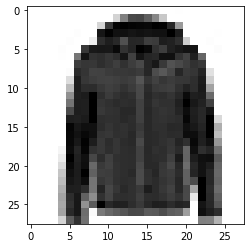

In [9]:
plt.imshow(X_train[0], cmap='binary')
plt.show()

Os rótulos são valores inteiros de 0 a 9, quardados nos vetores `y` e que correspondem aos seguintes nomes de classes.

Então a instância 0 é um **casaco**.

In [10]:
class_names = ['camiseta', 'calça', 'pulôver', 'vestido', 'casaco',
               'sandália', 'camisa', 'tênis', 'bolsa', 'bota']
class_names[y_train[0]]

'casaco'

Abaixo é exibido um mosaico com várias instâncias do conjunto de treino:

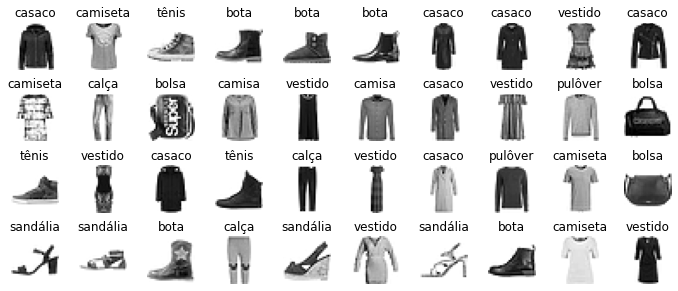

In [21]:
# não se preocupe com este código

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap='binary')
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Criando uma rede neural

Aqui vamos criar uma rede neural de classificação, usando um modelo (ou arquitetura) do tipo sequencial. O modelo sequencial corresponde ao tipo mais simples de rede neural, onde uma sequência de camadas de neurônios é empilhada uma em cima da outra.

- A criação começa com a chamada a `Sequential`, que define o tipo do modelo:

        model = keras.models.Sequential()

- Então uma camada do tipo `Flatten` é adicionada. Seu papel é apenas transformar a matriz de _pixels_ em um longo vetor. É uma camada de preprocessamento dos dados. Mas como esta é a primeira camada, é preciso definir o formato da entrada com `input_shape`:

        model.add(keras.layers.Flatten(input_shape=[28, 28]))

- A seguir adicionamos uma camada densa do tipo `Dense`, ou seja, totalmente conectada com a camada anterior. Esta conta com 300 neurônios e função de ativação ReLU:

        model.add(keras.layers.Dense(300, activation='relu'))
        
- Então uma segunda camada `Dense` é adicionada, agora com 100 neurônios e função de ativação também ReLU:
        
        model.add(keras.layers.Dense(100, activation='relu'))
        
- Finalmente uma camada de saída é adicionada. Aqui o tipo também é `Dense`, mas a função de ativação é trocada para `softmax` para produzir a saída de classificador (uma vez que as classes são mutuamente exclusivas):
        
        model.add(keras.layers.Dense(10, activation='softmax'))

Ainda que se possa criar uma rede neural com as diversas chamadas a `model.add(...)`, é mais conveniente criar o modelo passando uma lista de camadas, como mostrado a seguir.

In [11]:
# comando para 'zerar' a biblioteca Keras
keras.backend.clear_session()

# definição de sementes aleatórias
np.random.seed(42)
tf.random.set_seed(42)

In [12]:
# especificação do modelo
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [13]:
# resumo legível da arquitetura deste modelo
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Note que as camadas densas geralmente têm muitos parâmetros. Por exemplo, a primeira camada densa tem pesos de conexão de 784 × 300, além de mais 300 termos de _bias_, chegando a um total de 235.500 parâmetros.

Isso dá ao modelo bastante flexibilidade para ajustar os dados de treinamento, mas também significa que o modelo corre o risco de ter _overfitting_, especialmente quando não há muitos dados de treinamento.

## Arquitetura da rede neural

Podemos gerar uma figura da arquitetura deste modelo usando a função `keras.utils.plot_model`.

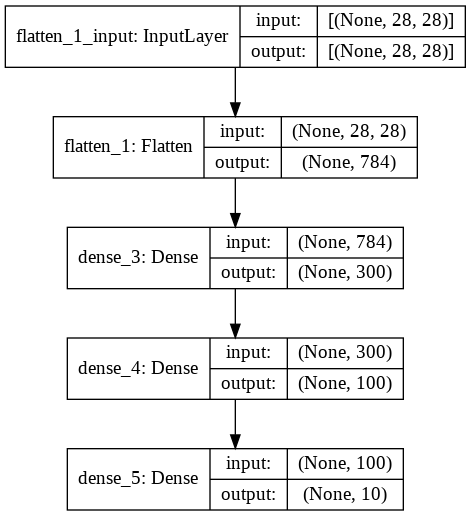

In [27]:
keras.utils.plot_model(model, 'fashion_mnist_model.png', show_shapes=True)

## Acesso às camadas

A biblioteca permite acessar cada camada criada, usando índices de acesso tal como em uma lista de Python.

Permite também ver atributos de cada camada, como o nome ou se é uma camada oculta. E ainda permite inspecionar os pesos de todas as conexões daquela camada.

In [14]:
# acesso a cada uma das camadas
model.layers

In [16]:
# primeira camada e respectivo nome
hidden1 = model.layers[1]
hidden1.name

'dense'

In [17]:
# encontra camada pelo nome
model.get_layer(hidden1.name)

In [18]:
# indica se a camada é ou não oculta
model.get_layer(hidden1.name) is hidden1

True

Observe que a camada `Dense` inicializa os pesos das conexão aleatoriamente. Os vieses foram inicializados apenas com zero.

In [19]:
# obtém pesos e vieses da camada
weights, biases = hidden1.get_weights()
print('weights:', weights.shape)
print('biases: ', biases.shape)

weights: (784, 300)
biases:  (300,)


In [20]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [35]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## Compilando a rede neural

Depois que um modelo é criado, é preciso chamar o método `compile()`, especificando a **função de perda** (aqui, a função `sparse_categorical_crossentropy`) e o **otimizador** a ser usado (`sgd`, algoritmo de descida do gradiente estocástico).

Opcionalmente, você também pode especificar uma lista de **medidas de desempenho** extras para calcular durante o treinamento e avaliação. Neste caso apenas é indicada a acurácia com `accuracy`.

In [21]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', 
              metrics=['accuracy'])

# Treinando e avaliando a rede neural

Para treinar o modelo basta chamar o método `fit()`. 

Três parâmetros são obrigatórios: as _features_ de treinamento, os rótulos de treinamento e o número de épocas.

Cada **época** (_epoch_) corresponde a uma etapa de atualização da rede neural.

Opcionalemente é passado também um conjunto de validação. A biblioteca Keras medirá a perda e as métricas extras ao final de cada época, o que é muito útil para ver como o modelo realmente funciona: se o desempenho no conjunto de treinamento é muito melhor do que no conjunto de validação, provavelmente está ocorrendo _overfitting_.

In [24]:
# esta chamada pode demorar um pouco
%time history = model.fit(X_train, y_train, epochs=25, validation_data=(X_valid, y_valid))

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 1.0187 - accuracy: 0.6805 - val_loss: 0.5213 - val_accuracy: 0.8226
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5027 - accuracy: 0.8262 - val_loss: 0.4353 - val_accuracy: 0.8526
Epoch 3/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4483 - accuracy: 0.8428 - val_loss: 0.5304 - val_accuracy: 0.7996
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4209 - accuracy: 0.8532 - val_loss: 0.3916 - val_accuracy: 0.8650
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4061 - accuracy: 0.8583 - val_loss: 0.3745 - val_accuracy: 0.8690
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3754 - accuracy: 0.8673 - val_loss: 0.3718 - val_accuracy: 0.8724
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3652 - accuracy: 0.8705 - val_loss: 0.3616 - val_accuracy:

In [25]:
# os dados do treinamento estão disponíveis no histórico retornado
print('parâmetros:', history.params)
print('métricas:  ', list(history.history.keys()))
print('épocas:    ', history.epoch)

parâmetros: {'verbose': 1, 'epochs': 25, 'steps': 1719}
métricas:   ['loss', 'accuracy', 'val_loss', 'val_accuracy']
épocas:     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


## Visualização da evolução das métricas ao longo do treinamento

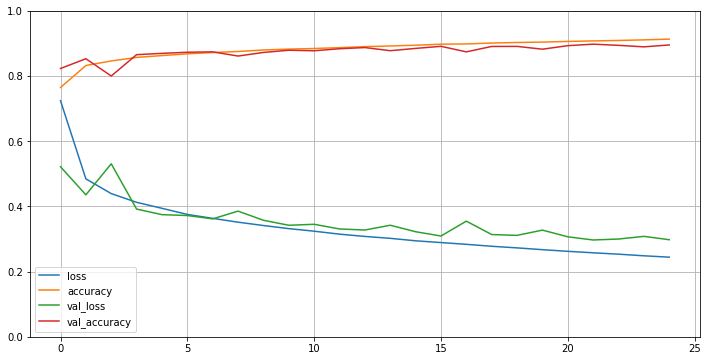

In [26]:
pd.DataFrame(history.history).plot(figsize=(12, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Avaliação final do modelo e geração de previsões

In [27]:
# avaliação com conjunto de teste
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3322 - accuracy: 0.8824


[0.33220893144607544, 0.8823999762535095]

In [28]:
# probabilidades computadas para três instâncias de teste
X_new = X_test[:3]
y_proba = model.predict(X_new)
print(y_proba.round(2))

[[0.   0.   0.   0.   0.   0.02 0.   0.02 0.   0.95]
 [0.   0.   0.99 0.   0.01 0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


In [29]:
# classes previstas e reais para as mesmas três instâncias de teste
y_pred = np.argmax(model.predict(X_new), axis=-1)
print('previstas: ', np.array(class_names)[y_pred])
print('reais:     ', np.array(class_names)[y_test[:3]])

previstas:  ['bota' 'pulôver' 'calça']
reais:      ['bota' 'pulôver' 'calça']


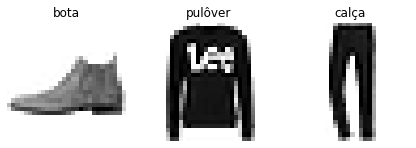

In [43]:
# visualização das tres instâncias
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()